# Imports 

In [1]:
%matplotlib inline
import numpy as np
import cv2
from incisorseg.dataset import Dataset,LeaveOneOutSplitter,appearance_model_eight_teeth,appearance_model_four_teeth,load_image,load_landmark,gaussian_pyramid_down,tooth_splitter,tooth_models
from incisorseg.utils import *
from active_shape_models.shape import Shape, ShapeList
from active_shape_models.models import AppearanceModel, GreyModel,PointDistributionModel,ActiveShapeModel
from active_shape_models.pca import PCAModel
import json

# Reading data

In [2]:
data = Dataset('../data/')

# Image preprocessing

In [3]:
'''
i = 0
for split in LeaveOneOutSplitter(data):
    #training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    sample = test_image[500:1500,1200:1800]
    transformed_sample = sample
    #transformed_sample = cv2.adaptiveBilateralFilter(transformed_sample,(9,9),5)
    #image_laplacian = cv2.Laplacian(transformed_sample,cv2.CV_32F)
    #image_scaled_laplacian = cv2.convertScaleAbs(image_laplacian,1,0)
    #transformed_sample = cv2.add(transformed_sample,image_scaled_laplacian)
    transformed_sample = cv2.medianBlur(sample,9)
    #canny_upper,_ = cv2.threshold(transformed_sample,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    #canny_lower = 0.1 * canny_upper
    #transformed_sample = cv2.bilateralFilter(transformed_sample,5,30,30)
    transformed_sample = cv2.Canny(transformed_sample,2,20)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    transformed_sample = cv2.morphologyEx(transformed_sample,cv2.MORPH_CLOSE,kernel)
    #imshow2(image_laplacian)
    imshow2(transformed_sample)
    #imshow2(sample)
    i+=1
    if i >0:
        pass#break
    '''

'\ni = 0\nfor split in LeaveOneOutSplitter(data):\n    #training_images,training_landmarks,training_segmentations = split.get_training_set()\n    test_image,test_landmark,test_segmentation = split.get_test_example()\n    sample = test_image[500:1500,1200:1800]\n    transformed_sample = sample\n    #transformed_sample = cv2.adaptiveBilateralFilter(transformed_sample,(9,9),5)\n    #image_laplacian = cv2.Laplacian(transformed_sample,cv2.CV_32F)\n    #image_scaled_laplacian = cv2.convertScaleAbs(image_laplacian,1,0)\n    #transformed_sample = cv2.add(transformed_sample,image_scaled_laplacian)\n    transformed_sample = cv2.medianBlur(sample,9)\n    #canny_upper,_ = cv2.threshold(transformed_sample,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)\n    #canny_lower = 0.1 * canny_upper\n    #transformed_sample = cv2.bilateralFilter(transformed_sample,5,30,30)\n    transformed_sample = cv2.Canny(transformed_sample,2,20)\n    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))\n    transformed_s

# Appearance Model

In [4]:
'''
pyr_levels = 0
for split in LeaveOneOutSplitter(data):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    shape,ta,tb = appearance_model_two_teeth(training_images,training_landmarks,test_image,pyr_levels,top_extent=[5,5],top_scale=[1,1],bottom_extent=[5,5],bottom_scale=[1,1])
    plot_shapes([test_landmark,shape.round()])
'''

'\npyr_levels = 0\nfor split in LeaveOneOutSplitter(data):\n    training_images,training_landmarks,training_segmentations = split.get_training_set()\n    test_image,test_landmark,test_segmentation = split.get_test_example()\n    shape,ta,tb = appearance_model_two_teeth(training_images,training_landmarks,test_image,pyr_levels,top_extent=[5,5],top_scale=[1,1],bottom_extent=[5,5],bottom_scale=[1,1])\n    plot_shapes([test_landmark,shape.round()])\n'

# Point Distribution Models - PCA Number of Components

In [5]:
'''
overall_error_list = []
for num_parts in [1,2,4,8]:
    for split_part in range(num_parts):
        error_list = []
        for nc in range(2,26):
            error = 0
            for split in LeaveOneOutSplitter(data):
                _,all_training_landmarks,_ = split.get_training_set()
                _,all_test_landmark,_ = split.get_test_example()
                split_training_landmarks = tooth_splitter(all_training_landmarks,num_parts)
                split_test_landmark = tooth_splitter([all_test_landmark],num_parts)
                training_landmarks = split_training_landmarks[split_part]
                test_landmark = split_test_landmark[split_part][0]
                model = PointDistributionModel(training_landmarks,project_to_tangent_space=False,
                                               pca_number_of_components=nc)
                _,fit_error,_ = model.fit(test_landmark)
                error += fit_error/test_landmark.get_size()
            error_list.append(error) 
        overall_error_list.append(error_list)
with open('../results/pdm_errors.json', 'w') as outfile:
    json.dump(overall_error_list, outfile)
'''

"\noverall_error_list = []\nfor num_parts in [1,2,4,8]:\n    for split_part in range(num_parts):\n        error_list = []\n        for nc in range(2,26):\n            error = 0\n            for split in LeaveOneOutSplitter(data):\n                _,all_training_landmarks,_ = split.get_training_set()\n                _,all_test_landmark,_ = split.get_test_example()\n                split_training_landmarks = tooth_splitter(all_training_landmarks,num_parts)\n                split_test_landmark = tooth_splitter([all_test_landmark],num_parts)\n                training_landmarks = split_training_landmarks[split_part]\n                test_landmark = split_test_landmark[split_part][0]\n                model = PointDistributionModel(training_landmarks,project_to_tangent_space=False,\n                                               pca_number_of_components=nc)\n                _,fit_error,_ = model.fit(test_landmark)\n                error += fit_error/test_landmark.get_size()\n            erro

In [6]:
'''
with open('../results/pdm_errors.json') as data_file:    
    overall_error_list = json.load(data_file)
for error_list in overall_error_list:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(error_list)
    ax.set_title('Number of Components vs Error')
    ax.set_xlabel('Number of Principal Components')
    ax.set_ylabel('Error')
'''    

"\nwith open('../results/pdm_errors.json') as data_file:    \n    overall_error_list = json.load(data_file)\nfor error_list in overall_error_list:\n    fig = plt.figure()\n    ax = fig.add_subplot(111)\n    ax.plot(error_list)\n    ax.set_title('Number of Components vs Error')\n    ax.set_xlabel('Number of Principal Components')\n    ax.set_ylabel('Error')\n"

In [7]:
'''
for split in LeaveOneOutSplitter(data):
    _,all_training_landmarks,_ = split.get_training_set()
    _,all_test_landmark,_ = split.get_test_example()
    model_list, training_landmarks_list, test_landmark_list, error_list = tooth_models(all_training_landmarks,all_test_landmark,pca_variance_captured=[0.94,0.96,0.98,0.99])
    print error_list
    #print model_list
'''

'\nfor split in LeaveOneOutSplitter(data):\n    _,all_training_landmarks,_ = split.get_training_set()\n    _,all_test_landmark,_ = split.get_test_example()\n    model_list, training_landmarks_list, test_landmark_list, error_list = tooth_models(all_training_landmarks,all_test_landmark,pca_variance_captured=[0.94,0.96,0.98,0.99])\n    print error_list\n    #print model_list\n'

# Ideal case - testing the shape model fitting

In [8]:
'''
errors = []
for split in LeaveOneOutSplitter(data):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    shape_model = PointDistributionModel(training_landmarks,pca_variance_captured=0.98)
    fitted_shape,_,num_iters =shape_model.fit(test_landmark)
    errors.append(split.get_dice_error_on_test(fitted_shape))
print np.mean(np.array(errors))
'''

'\nerrors = []\nfor split in LeaveOneOutSplitter(data):\n    training_images,training_landmarks,training_segmentations = split.get_training_set()\n    test_image,test_landmark,test_segmentation = split.get_test_example()\n    shape_model = PointDistributionModel(training_landmarks,pca_variance_captured=0.98)\n    fitted_shape,_,num_iters =shape_model.fit(test_landmark)\n    errors.append(split.get_dice_error_on_test(fitted_shape))\nprint np.mean(np.array(errors))\n'

# Ideal case - testing the grey model fitting

In [9]:
'''
pyr_levels=4
for split in LeaveOneOutSplitter(data):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    scaled_training_images,scaled_training_landmarks = gaussian_pyramid_down(
        training_images,num_levels=pyr_levels, training_landmarks=training_landmarks)
    scaled_test_image,scaled_test_landmark = gaussian_pyramid_down([test_image],training_landmarks=[test_landmark],num_levels=pyr_levels)
    scaled_test_image = scaled_test_image[0]
    scaled_test_landmark = scaled_test_landmark[0]
    all_teeth_shape_model = PointDistributionModel(scaled_training_landmarks,pca_variance_captured=0.99)
    all_teeth_app_model = AppearanceModel(scaled_training_images,all_teeth_shape_model,[6,6])
    fitted_shape_appearance = all_teeth_app_model.fit(transformed_test_image)
    
    upper_teeth_shape_model = PointDistributionModel(upper_teeth_training_landmarks,pca_variance_captured=0.9)
    lower_teeth_shape_model = PointDistributionModel(lower_teeth_training_landmarks,pca_variance_captured=0.9)
    transformed_test_image = scaled_test_image
    transformed_training_images = scaled_training_images
    #transformed_training_images = [cv2.Laplacian(image,ddepth=cv2.CV_32F) for image in scaled_training_images]
    #transformed_test_image = cv2.Laplacian(scaled_test_image,ddepth=cv2.CV_32F)
    transformed_training_images = [cv2.medianBlur(image,3) for image in scaled_training_images]
    transformed_test_image = cv2.medianBlur(scaled_test_image,3)
    grey_model = GreyModel(transformed_training_images, upper_teeth_training_landmarks,patch_num_pixels=5*(5-pyr_levels), 
                           search_num_pixels=40*(5-pyr_levels), use_gradient=True,
                 normalize_patch=True, use_moded_pca_model=False, mpca_variance_captured=0.9,
                 normal_point_neighborhood=1)
    model=ActiveShapeModel(grey_model=grey_model,point_distribution_model=upper_teeth_shape_model,appearance_model=None)
    new_shape,fit_error,num_iters = model.fit(scaled_test_image,0.2,100, initial_shape=upper_teeth_initial_position)
    print num_iters
    plot_shapes([upper_teeth_test_landmark,new_shape])
    #fitted_shape_grey,_ =grey_model.search(transformed_test_image,upper_teeth_initial_position.round())
    #fitted_shape,_,_=upper_teeth_shape_model.fit(fitted_shape_grey)
    #fitted_shape_grey,_ =grey_model.search(transformed_test_image,fitted_shape.round())
    #fitted_shape,_,_=upper_teeth_shape_model.fit(fitted_shape_grey)
    #plot_shapes([upper_teeth_test_landmark,fitted_shape_grey,fitted_shape])
    #for j in range(0,pyr_levels):
    #    fitted_shape = fitted_shape.pyr_up()
    #error_list.append(split.get_dice_error_on_test(fitted_shape))

#plot_shapes([test_landmark,fitted_shape])
print np.mean(np.array(error_list))
'''

'\npyr_levels=4\nfor split in LeaveOneOutSplitter(data):\n    training_images,training_landmarks,training_segmentations = split.get_training_set()\n    test_image,test_landmark,test_segmentation = split.get_test_example()\n    scaled_training_images,scaled_training_landmarks = gaussian_pyramid_down(\n        training_images,num_levels=pyr_levels, training_landmarks=training_landmarks)\n    scaled_test_image,scaled_test_landmark = gaussian_pyramid_down([test_image],training_landmarks=[test_landmark],num_levels=pyr_levels)\n    scaled_test_image = scaled_test_image[0]\n    scaled_test_landmark = scaled_test_landmark[0]\n    all_teeth_shape_model = PointDistributionModel(scaled_training_landmarks,pca_variance_captured=0.99)\n    all_teeth_app_model = AppearanceModel(scaled_training_images,all_teeth_shape_model,[6,6])\n    fitted_shape_appearance = all_teeth_app_model.fit(transformed_test_image)\n    \n    upper_teeth_shape_model = PointDistributionModel(upper_teeth_training_landmarks,pca_

0 0.53551394388 0.424274554531 0.971831316259


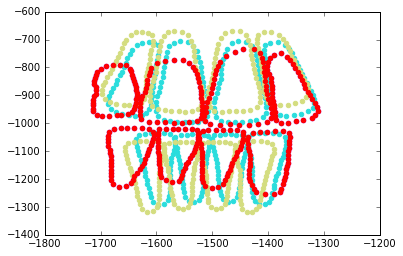

iters:  13 6 1 i: 1
iters:  0 1 17 i: 1
1 0.617622610141 0.467189929486 0.767592559661


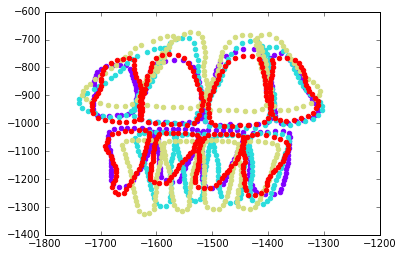

iters:  13 13 4 i: 2
iters:  1 1 2 i: 2
iters:  3 0 9 i: 2
iters:  3 3 1 i: 2
2 0.640635465113 0.497829038295 0.762853084194


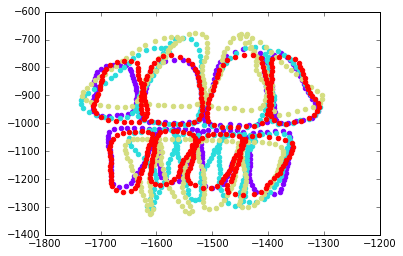

iters:  2 11 2 i: 3
iters:  7 1 1 i: 3
iters:  6 3 5 i: 3
iters:  3 10 2 i: 3
iters:  1 0 10 i: 3
iters:  11 13 9 i: 3
iters:  1 4 5 i: 3
iters:  2 5 5 i: 3
3 0.6152143712 0.521267495404 0.774520195596


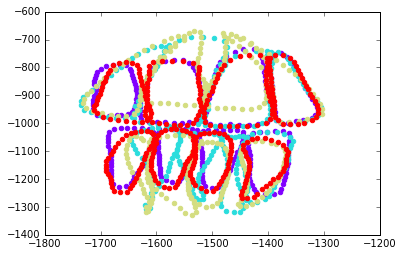

0 0.657401366731 0.617405795042 0.966536161292


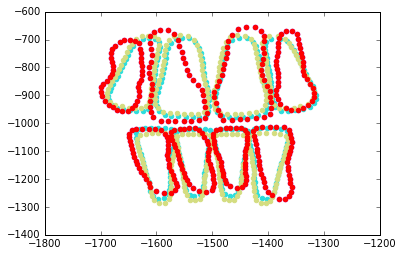

iters:  12 13 33 i: 1
iters:  9 0 9 i: 1
1 0.722715017257 0.70161525608 0.730521186329


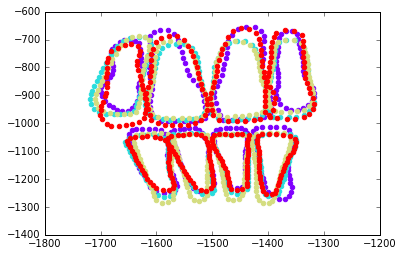

iters:  7 11 4 i: 2
iters:  6 10 4 i: 2
iters:  3 2 2 i: 2
iters:  1 4 2 i: 2
2 0.733337383802 0.730260664925 0.728315329515


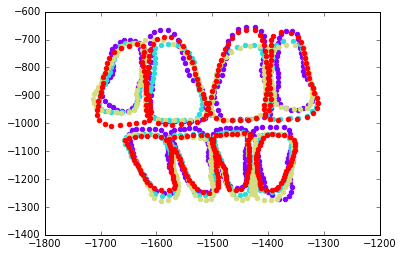

iters:  28 2 2 i: 3
iters:  7 1 29 i: 3
iters:  2 3 3 i: 3
iters:  10 6 16 i: 3
iters:  2 1 3 i: 3
iters:  3 5 8 i: 3
iters:  9 2 5 i: 3
iters:  1 1 1 i: 3
3 0.706473061949 0.720418197011 0.684299238344


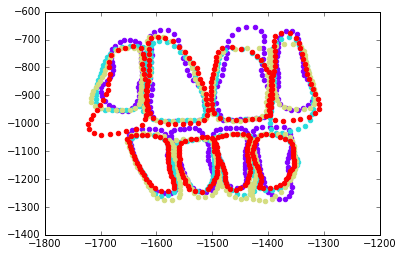

0 0.453975513419 0.668402329608 0.967876239566


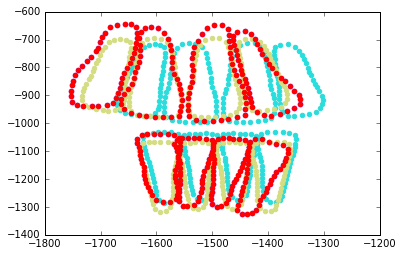

iters:  13 9 7 i: 1
iters:  16 6 5 i: 1
1 0.451852270728 0.742509332901 0.812427499807


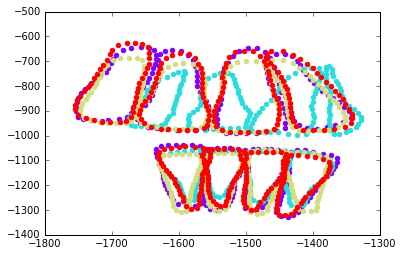

iters:  3 0 4 i: 2
iters:  4 2 0 i: 2
iters:  1 8 4 i: 2
iters:  10 5 5 i: 2
2 0.430093842396 0.740418796709 0.783332100865


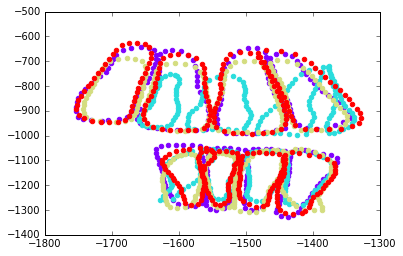

iters:  1 3 0 i: 3
iters:  1 4 1 i: 3
iters:  1 6 6 i: 3
iters:  10 9 0 i: 3
iters:  1 5 1 i: 3
iters:  2 2 0 i: 3
iters:  7 2 3 i: 3
iters:  2 9 1 i: 3
3 0.380169224335 0.727894893018 0.774989569784


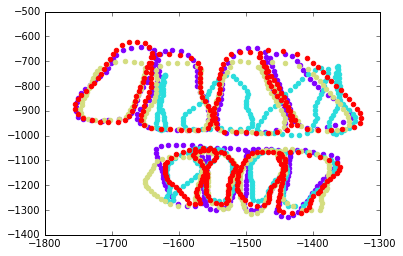

0 0.398999696704 0.53312664625 0.966266302302


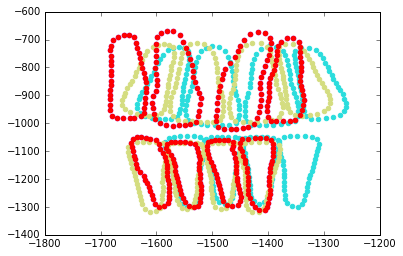

iters:  0 32 1 i: 1
iters:  23 6 17 i: 1
1 0.372434735474 0.638705981319 0.761458917605


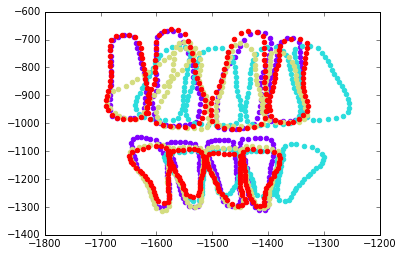

iters:  0 1 4 i: 2
iters:  5 0 4 i: 2
iters:  0 14 7 i: 2
iters:  2 4 2 i: 2
2 0.413344191595 0.621092262786 0.722381610665


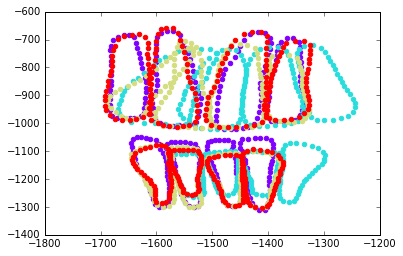

iters:  0 1 4 i: 3
iters:  2 2 0 i: 3
iters:  3 7 1 i: 3
iters:  9 1 5 i: 3
iters:  9 1 1 i: 3
iters:  1 9 5 i: 3
iters:  6 0 4 i: 3
iters:  2 1 1 i: 3
3 0.414278300319 0.620305341319 0.727351446498


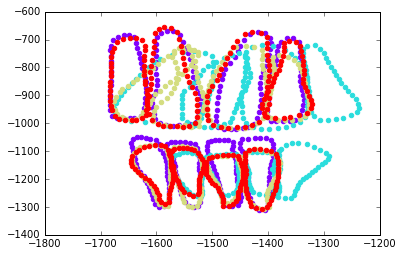

0 0.600082300822 0.575908178051 0.943529540928


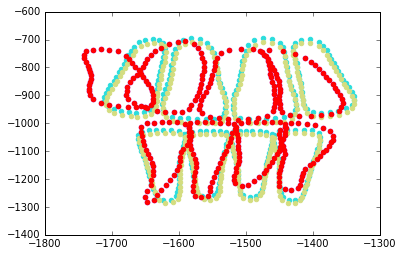

iters:  2 1 5 i: 1
iters:  14 20 9 i: 1
1 0.572459494384 0.52766650526 0.764248886641


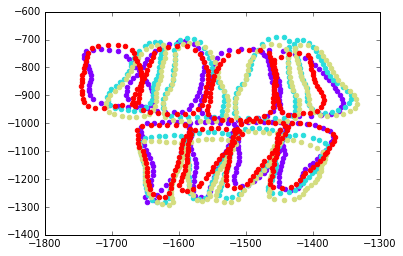

iters:  5 0 1 i: 2
iters:  3 5 0 i: 2
iters:  5 3 16 i: 2
iters:  7 12 1 i: 2
2 0.539285103247 0.501500384396 0.768628517248


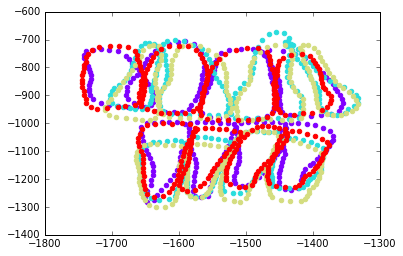

iters:  0 4 9 i: 3
iters:  1 2 14 i: 3
iters:  2 3 1 i: 3
iters:  2 10 1 i: 3
iters:  12 11 1 i: 3
iters:  2 0 4 i: 3
iters:  4 5 1 i: 3
iters:  14 0 0 i: 3
3 0.516853565667 0.470381557828 0.748295581033


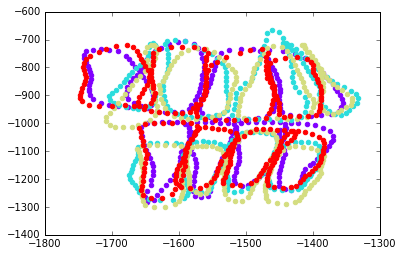

0 0.391680193903 0.442119266586 0.9670852981


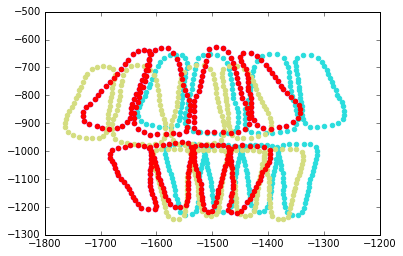

iters:  0 15 6 i: 1
iters:  9 11 6 i: 1
1 0.449805026121 0.476141680826 0.83086533188


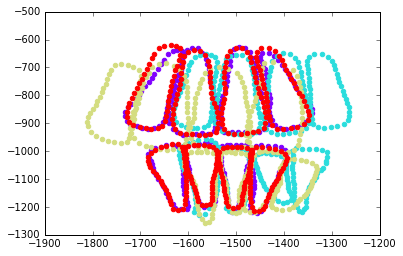

iters:  8 8 1 i: 2
iters:  6 5 4 i: 2
iters:  7 4 0 i: 2
iters:  7 12 5 i: 2
2 0.441168738919 0.463417162524 0.822984819329


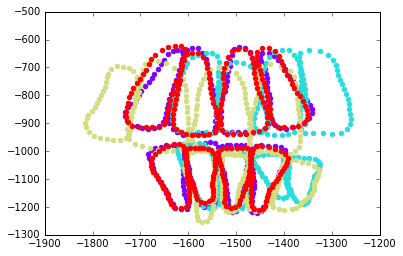

iters:  33 2 0 i: 3
iters:  5 4 16 i: 3
iters:  0 9 3 i: 3
iters:  4 9 3 i: 3
iters:  3 1 3 i: 3
iters:  3 0 5 i: 3
iters:  2 0 11 i: 3
iters:  0 10 1 i: 3
3 0.456308745083 0.47689761271 0.754855205304


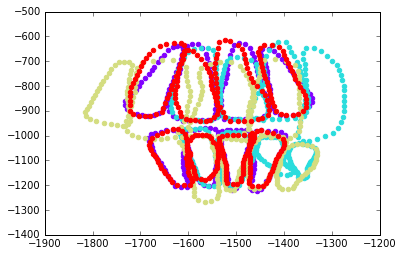

0 0.756114549972 0.703979681793 0.964634246016


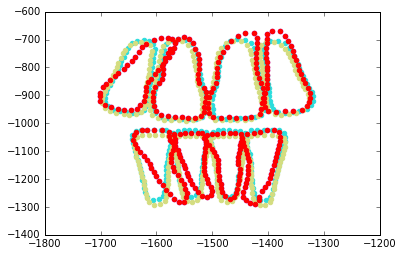

iters:  22 0 4 i: 1
iters:  13 17 6 i: 1
1 0.708176603171 0.670525540741 0.797061365601


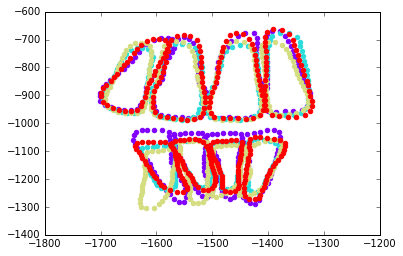

iters:  8 2 3 i: 2
iters:  2 0 3 i: 2
iters:  6 3 10 i: 2
iters:  5 0 3 i: 2
2 0.696998574267 0.686317029038 0.721940372617


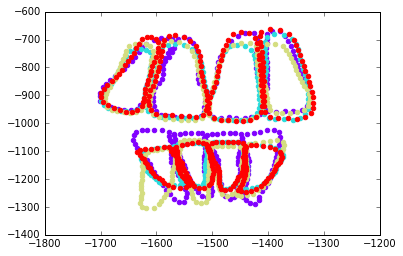

iters:  5 0 4 i: 3
iters:  11 0 1 i: 3
iters:  2 2 2 i: 3
iters:  5 0 2 i: 3
iters:  9 5 8 i: 3
iters:  10 0 2 i: 3
iters:  1 2 5 i: 3
iters:  4 11 0 i: 3
3 0.646049333274 0.666352944557 0.730308388791


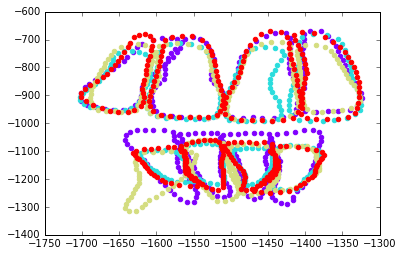

0 0.364555487233 0.414003730916 0.960646529623


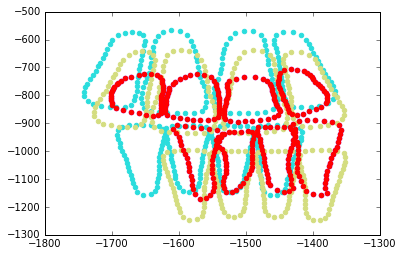

iters:  14 3 4 i: 1
iters:  0 5 3 i: 1
1 0.375913123086 0.460510310367 0.818842118202


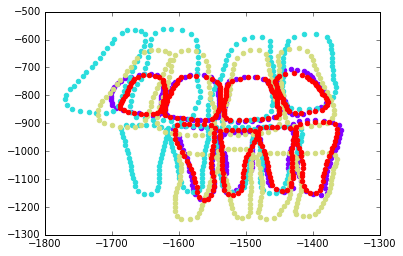

iters:  10 1 1 i: 2
iters:  8 0 1 i: 2
iters:  8 4 6 i: 2
iters:  0 3 8 i: 2
2 0.351736325103 0.444512795276 0.809791075118


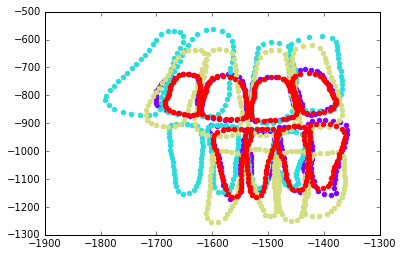

iters:  1 0 0 i: 3
iters:  6 7 1 i: 3
iters:  5 0 6 i: 3
iters:  6 1 4 i: 3
iters:  1 4 0 i: 3
iters:  2 7 6 i: 3
iters:  0 1 0 i: 3
iters:  0 5 0 i: 3
3 0.357004779206 0.440451390067 0.774018884951


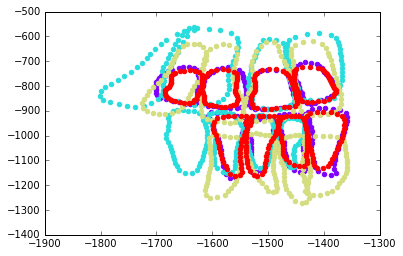

0 0.386858111713 0.419051679508 0.954281121887


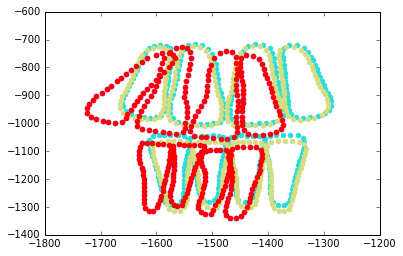

iters:  30 20 5 i: 1
iters:  0 2 2 i: 1
1 0.472784267337 0.48956972841 0.816932275662


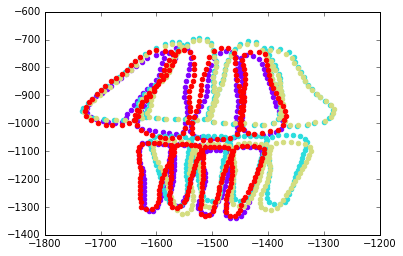

iters:  4 1 8 i: 2
iters:  20 6 0 i: 2
iters:  3 8 2 i: 2
iters:  1 0 1 i: 2
2 0.462004293169 0.46891462841 0.795053462653


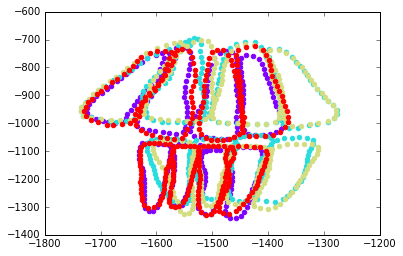

iters:  1 3 18 i: 3
iters:  7 11 5 i: 3
iters:  1 1 3 i: 3
iters:  6 10 0 i: 3
iters:  8 7 2 i: 3
iters:  6 1 2 i: 3
iters:  16 3 2 i: 3
iters:  8 1 0 i: 3
3 0.476568542433 0.470550029257 0.734253752478


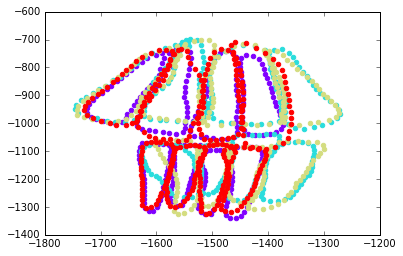

0 0.402555093509 0.472015591439 0.964430072757


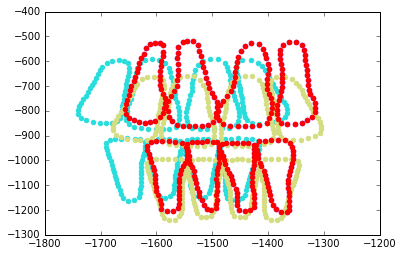

iters:  16 1 9 i: 1
iters:  0 0 1 i: 1
1 0.431201683489 0.468001945491 0.801181950085


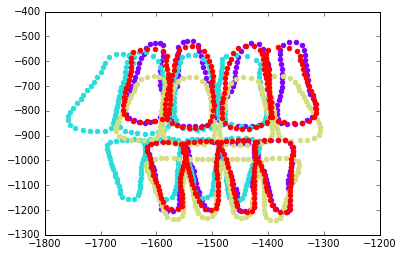

iters:  7 9 3 i: 2
iters:  2 0 1 i: 2
iters:  0 0 1 i: 2
iters:  0 0 1 i: 2
2 0.436436056197 0.470870191673 0.792202662313


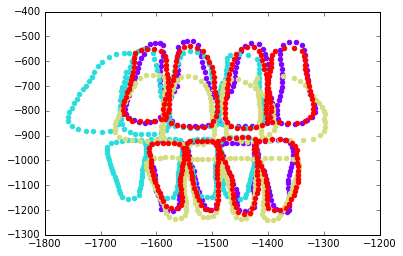

iters:  0 2 0 i: 3
iters:  0 2 4 i: 3
iters:  1 2 1 i: 3
iters:  8 9 7 i: 3
iters:  4 2 7 i: 3
iters:  0 0 3 i: 3
iters:  0 0 0 i: 3
iters:  1 0 4 i: 3
3 0.442609386738 0.468512562871 0.761627682445


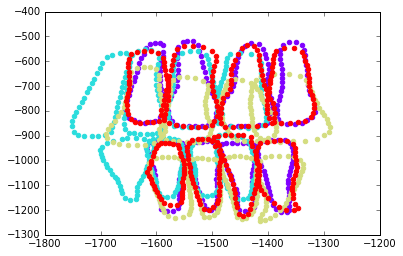

0 0.454616471193 0.530373567764 0.970038366712


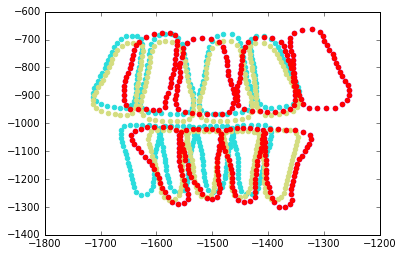

iters:  7 0 15 i: 1
iters:  7 7 5 i: 1
1 0.359216057459 0.513425925926 0.762307815602


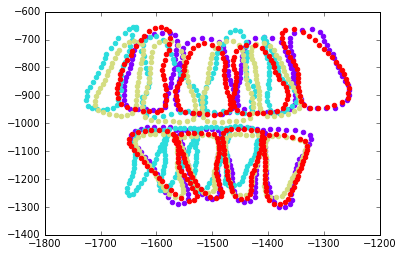

iters:  1 3 1 i: 2
iters:  20 0 3 i: 2
iters:  2 2 3 i: 2
iters:  6 0 8 i: 2
2 0.323749581226 0.480834933402 0.722672339923


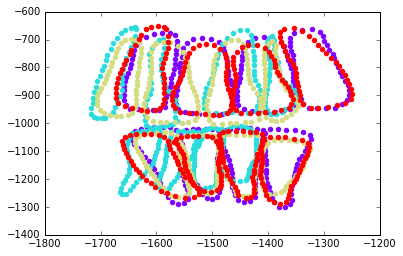

iters:  4 5 0 i: 3
iters:  0 0 13 i: 3
iters:  1 5 12 i: 3
iters:  21 6 2 i: 3
iters:  4 1 2 i: 3
iters:  3 4 5 i: 3
iters:  2 1 1 i: 3
iters:  4 0 2 i: 3
3 0.291662602551 0.407223864553 0.613088350456


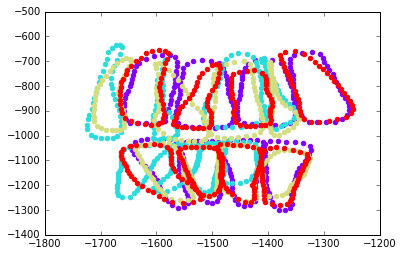

0 0.456277805936 0.468913430709 0.957612808598


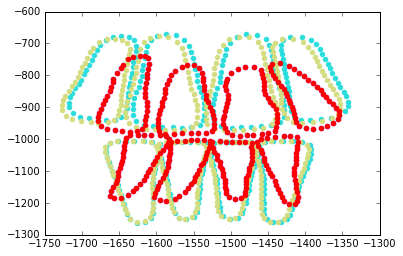

iters:  13 19 8 i: 1
iters:  0 0 10 i: 1
1 0.590608585759 0.494991396483 0.755122233994


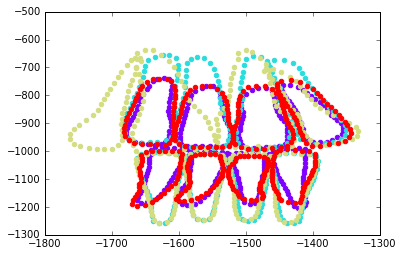

iters:  2 1 3 i: 2
iters:  4 6 3 i: 2
iters:  2 0 8 i: 2
iters:  0 7 5 i: 2
2 0.583928417116 0.477234596471 0.714661603408


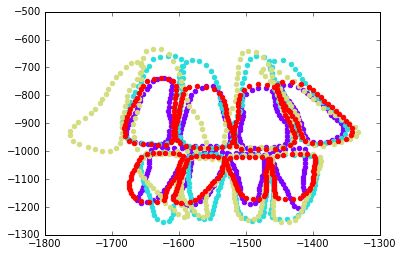

iters:  2 1 1 i: 3
iters:  2 0 0 i: 3
iters:  18 5 8 i: 3
iters:  1 0 2 i: 3
iters:  1 2 3 i: 3
iters:  6 1 2 i: 3
iters:  2 3 6 i: 3
iters:  0 0 0 i: 3
3 0.586023240801 0.476213961615 0.703005409928


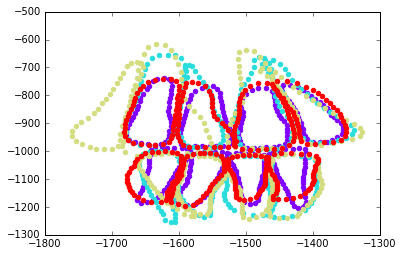

0 0.606891876035 0.368661720804 0.96356898792


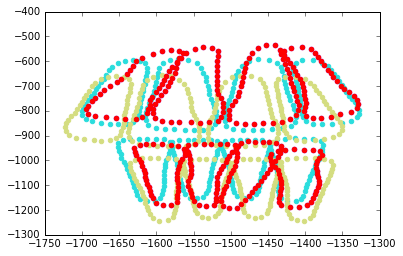

iters:  0 11 1 i: 1
iters:  8 3 4 i: 1
1 0.638264656054 0.437936748466 0.839201424404


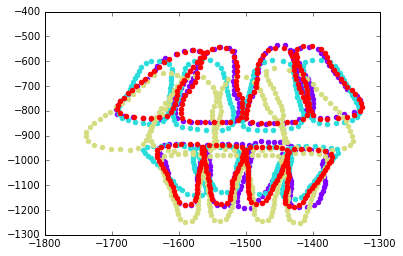

iters:  0 2 11 i: 2
iters:  1 6 2 i: 2
iters:  2 0 2 i: 2
iters:  2 2 10 i: 2
2 0.6487252924 0.450855692922 0.769376683766


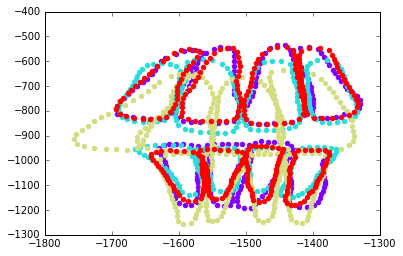

iters:  0 1 1 i: 3
iters:  1 10 1 i: 3
iters:  0 7 0 i: 3
iters:  0 1 1 i: 3
iters:  1 2 3 i: 3
iters:  7 1 1 i: 3
iters:  1 8 0 i: 3
iters:  4 0 4 i: 3
3 0.659888569502 0.441636270298 0.776596287788


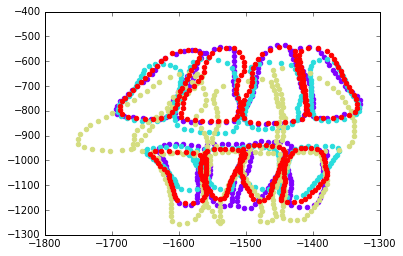

0 0.58566375563 0.652430806895 0.971704849015


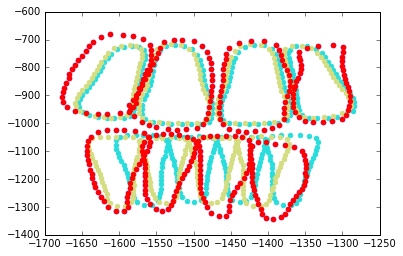

iters:  5 6 9 i: 1
iters:  0 2 6 i: 1
1 0.598051197911 0.655809009987 0.725422438113


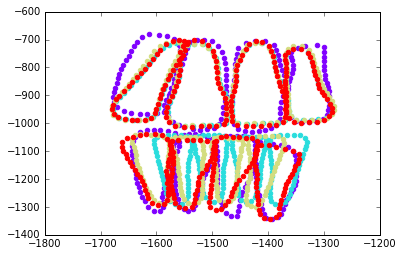

iters:  2 3 4 i: 2
iters:  1 3 2 i: 2
iters:  3 0 15 i: 2
iters:  5 8 0 i: 2
2 0.563220148007 0.662407805998 0.677750267258


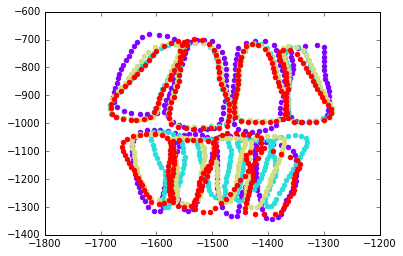

iters:  18 9 1 i: 3
iters:  18 4 2 i: 3
iters:  4 3 3 i: 3
iters:  4 8 11 i: 3
iters:  2 1 14 i: 3
iters:  2 3 3 i: 3
iters:  10 5 1 i: 3
iters:  2 1 7 i: 3
3 0.582835893923 0.693206473515 0.697760249937


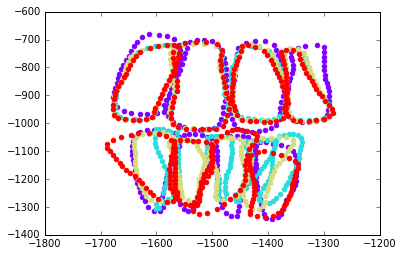

0 0.547462612627 0.449551066545 0.963794487348


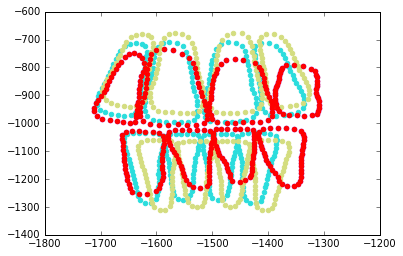

iters:  6 5 3 i: 1
iters:  3 1 0 i: 1
1 0.602181364518 0.480700707273 0.900623137771


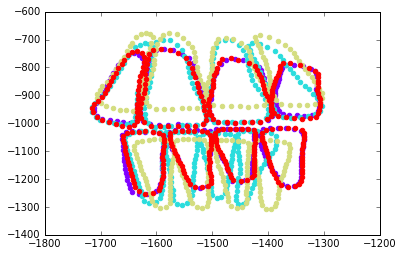

iters:  1 11 2 i: 2
iters:  4 2 3 i: 2
iters:  1 0 2 i: 2
iters:  1 3 1 i: 2
2 0.622697316558 0.511466279499 0.853611438573


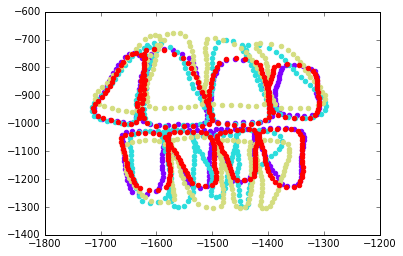

iters:  5 20 0 i: 3
iters:  0 1 6 i: 3
iters:  3 19 0 i: 3
iters:  11 4 6 i: 3
iters:  0 0 6 i: 3
iters:  1 0 3 i: 3
iters:  17 0 3 i: 3
iters:  2 0 1 i: 3
3 0.617127888317 0.523726631934 0.795735635146


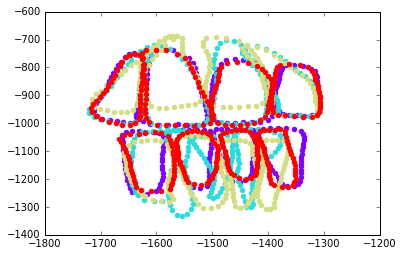

In [10]:
k = 0
for split in LeaveOneOutSplitter(data):
    training_images, all_training_landmarks,_ = split.get_training_set()
    test_image, all_test_landmark,_ = split.get_test_example()
    model_list, training_landmarks_list, test_landmark_list, error_list = tooth_models(all_training_landmarks,all_test_landmark,
                                                                                      project_to_tangent_space=True,pca_variance_captured=[0.94,0.96,0.98,0.99])
    transformed_train_imgs = training_images
    transformed_test_imgs = test_image
    transformed_test_imgs = cv2.medianBlur(test_image,9)
    transformed_train_imgs = [cv2.medianBlur(sample,9) for sample in training_images]
    initial_shape = appearance_model_eight_teeth(training_images,all_training_landmarks,test_image,pyr_levels=0,top_extent=[6,6])
    initial_shape_2 = appearance_model_four_teeth(training_images,all_training_landmarks,test_image,pyr_levels=0,top_extent=[7,7],top_scale=[1.1,1.1],bottom_extent=[6,6],bottom_scale=[1.05,1.1])
    initial_error = split.get_dice_error_on_test(initial_shape)
    initial_error_2 = split.get_dice_error_on_test(initial_shape_2)
    initial_error_3 = split.get_dice_error_on_test(all_test_landmark)
    print 0,initial_error,initial_error_2,initial_error_3
    new_shape = initial_shape
    new_shape_2 = initial_shape_2
    new_shape_3 = all_test_landmark
    plot_shapes([all_test_landmark,new_shape.round(),new_shape_2.round(),new_shape_3.round()])
    search_num_pixels = [50,50,50,50]
    for i in range(1,len(model_list)):
        init_shapes = ShapeList.from_shape(new_shape, len(model_list[i])) #splits shapes
        init_shapes_2 = ShapeList.from_shape(new_shape_2, len(model_list[i])) #splits shapes
        init_shapes_3 = ShapeList.from_shape(new_shape_3, len(model_list[i])) #splits shapes
        new_shape = None
        new_shape_2 = None
        new_shape_3 = None
        for j in range(len(model_list[i])):
            grey_model = GreyModel(transformed_train_imgs,training_landmarks_list[i][j],
                               patch_num_pixels=30,
                               search_num_pixels=search_num_pixels[i],
                               use_gradient=True,normalize_patch = True)
            model = ActiveShapeModel(grey_model=grey_model,point_distribution_model=model_list[i][j],appearance_model=None)
            new_shape_part,fit_error,num_iters = model.fit(transformed_test_imgs,0.3,1000, initial_shape=init_shapes[j])
            new_shape_part_2,fit_error,num_iters_2 = model.fit(transformed_test_imgs,0.3,1000, initial_shape=init_shapes_2[j])
            new_shape_part_3,fit_error,num_iters_3 = model.fit(transformed_test_imgs,0.3,1000, initial_shape=init_shapes_3[j])
            print "iters: ", num_iters, num_iters_2,num_iters_3,"i:", i
            if new_shape is None:
                new_shape = new_shape_part
            else:
                new_shape=new_shape.concatenate(new_shape_part)
            if new_shape_2 is None:
                new_shape_2 = new_shape_part_2
            else:
                new_shape_2=new_shape_2.concatenate(new_shape_part_2)
            if new_shape_3 is None:
                new_shape_3 = new_shape_part_3
            else:
                new_shape_3=new_shape_3.concatenate(new_shape_part_3)
        print i, split.get_dice_error_on_test(new_shape),split.get_dice_error_on_test(new_shape_2),split.get_dice_error_on_test(new_shape_3)
        plot_shapes([all_test_landmark,new_shape.round(),new_shape_2.round(),new_shape_3.round()])
    k+=1
    if k>=3:
        pass#break

In [11]:
'''
i = 0
pyr_levels = 4
for split in LeaveOneOutSplitter(data):
    if i >=1:
        pass#break
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    scaled_training_images = []
    scaled_training_landmarks = []
    scaled_test_images = []
    scaled_test_landmarks = []
    scaled_training_images.append(training_images)
    scaled_training_landmarks.append(ShapeList([ShapeList.from_shape(landmark,1)[0] for landmark in training_landmarks]))
    scaled_test_images.append(test_image)
    scaled_test_landmarks.append(ShapeList.from_shape(test_landmark,1)[0])
    for j in range(1,pyr_levels):
        scaled_test_images.append(cv2.pyrDown(scaled_test_images[j-1]))
        scaled_test_landmarks.append(scaled_test_landmarks[j-1].pyr_down())
        scaled_training_images.append([cv2.pyrDown(image) for image in scaled_training_images[j-1]])
        scaled_training_landmarks.append(ShapeList([shape.pyr_down() for shape in scaled_training_landmarks[j-1]]))
    new_shape = None
    #print 'Test Landmarks Accuracy %f',split.get_dice_error_on_test(test_landmark)
    detected_shapes = []
    for j in range(pyr_levels-1,-1,-1):
        shape_model = PointDistributionModel(scaled_training_landmarks[j],pca_variance_captured=0.9)
        grey_model = GreyModel(scaled_training_images[j],scaled_training_landmarks[j],
                               patch_num_pixels=5*(pyr_levels-j),
                               search_num_pixels=7*(pyr_levels-j))
        app_model = AppearanceModel(scaled_training_images[j],shape_model,[6,6])
        model = ActiveShapeModel(grey_model=grey_model,point_distribution_model=shape_model,appearance_model=app_model)
        new_shape,fit_error,num_iters = model.fit(scaled_test_images[j],0.5,100, initial_shape=new_shape)
        if j == pyr_levels-1:     
            detected_shapes.append(model.get_default_initial_shape())
        detected_shapes.append(new_shape)
        if j == 0:
            imshow2(overlay_shapes_on_image(scaled_test_images[j],[new_shape.round()]))
        #plot_shapes([new_shape])
        new_shape = new_shape.pyr_up()
    i +=1
    for j in range(len(detected_shapes)):
        if j==0:
            scale_start = 1
        else:
            scale_start = j
        for k in range(scale_start,pyr_levels):
            detected_shapes[j]=detected_shapes[j].pyr_up()
        
        #print 'Level:' , j, 'Accuracy',split.get_dice_error_on_test(detected_shapes[j]) 
'''

"\ni = 0\npyr_levels = 4\nfor split in LeaveOneOutSplitter(data):\n    if i >=1:\n        pass#break\n    training_images,training_landmarks,training_segmentations = split.get_training_set()\n    test_image,test_landmark,test_segmentation = split.get_test_example()\n    scaled_training_images = []\n    scaled_training_landmarks = []\n    scaled_test_images = []\n    scaled_test_landmarks = []\n    scaled_training_images.append(training_images)\n    scaled_training_landmarks.append(ShapeList([ShapeList.from_shape(landmark,1)[0] for landmark in training_landmarks]))\n    scaled_test_images.append(test_image)\n    scaled_test_landmarks.append(ShapeList.from_shape(test_landmark,1)[0])\n    for j in range(1,pyr_levels):\n        scaled_test_images.append(cv2.pyrDown(scaled_test_images[j-1]))\n        scaled_test_landmarks.append(scaled_test_landmarks[j-1].pyr_down())\n        scaled_training_images.append([cv2.pyrDown(image) for image in scaled_training_images[j-1]])\n        scaled_trainin